In [1]:
import sys
from datasets import load_dataset
from loguru import logger

logger.configure(handlers=[{"sink": sys.stdout, "level": "WARNING"}])
ds = load_dataset("CharlyR/vtikz", "tikz", split="benchmark")
ds = ds.select_columns(["id","type","instruction","code","template_solution_code"])


/home/creux/Documents/AI/VIFagent/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Utils

In [1]:
from datasets.formatting.formatting import LazyBatch
from collections import defaultdict
from notebooks.verifier_ds_creation.verifier_utils import (
    generate_all_incorrect_solutions,
    get_default,
    handle_def,
)


def create_incorrect_solutions(row: LazyBatch):
    all_created_template_codes: dict[str : list[str]] = defaultdict(list)
    original_code = row["code"][0]
    ignored_row = []
    for template_code in row["template_solution_code"][0]:
        all_created_template_codes[template_code], ignored = (
            generate_all_incorrect_solutions(original_code, template_code)
        )
        ignored_row.append(ignored)

    if all(ignored_row):
        logger.warning(f"{row['id']} is ignored.")

    new_rows = defaultdict(list)
    for template, created_template_codes in all_created_template_codes.items():
        for created_template_code in created_template_codes:
            for existing_col in set(row.keys()):
                new_rows[existing_col].append(row[existing_col][0])
            new_rows["original_template"].append(template)
            new_rows["solution"].append(created_template_code)
            new_rows["expected"].append(False)
    if len(new_rows) == 0:
        new_rows = {
            "original_template": [],
            "solution": [],
            "expected": [],
        }
        for existing_col in set(row.keys()):
            new_rows[existing_col] = []
    return new_rows


def create_default_solution(row: LazyBatch):
    default_codes: dict[str, str] = {}
    for template_code in row["template_solution_code"][0]:
        default_codes[template_code] = get_default(handle_def(template_code)[0])
    new_rows = defaultdict(list)
    for template, created_default_code in default_codes.items():
        for existing_col in set(row.keys()):
            new_rows[existing_col].append(row[existing_col][0])
        new_rows["original_template"].append(template)
        new_rows["solution"].append(created_default_code)
        new_rows["expected"].append(True)
    return new_rows


/home/creux/Documents/AI/VIFagent/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Creating the dataset + filtering

In [18]:
expanded_ds_cor = ds.map(create_default_solution,batched=True,batch_size=1,load_from_cache_file=False)

Map: 100%|██████████| 100/100 [00:00<00:00, 980.83 examples/s]


In [5]:
expanded_ds_inc = ds.select(range(len(ds) - 1, -1, -1)).map(create_incorrect_solutions,batched=True,batch_size=1,load_from_cache_file=False)

Map:  96%|█████████▌| 96/100 [31:38<01:32, 23.11s/ examples]  

2025-10-31 10:44:02.270 | WARNING  | __main__:create_incorrect_solutions:21 - ['bee_mirrored'] is ignored.


Map: 100%|██████████| 100/100 [32:26<00:00, 19.46s/ examples]


In [19]:
from datasets import Dataset,concatenate_datasets
generated_ds:Dataset = concatenate_datasets([expanded_ds_cor,expanded_ds_inc])

In [22]:
len(expanded_ds_cor)

140

#### Filtering the ones that do not compile

In [23]:
import sys
from vif.utils.renderer.tex_renderer import TexRenderer


renderer = TexRenderer()

def renders(row):
    try:
        renderer.from_string_to_image(row["solution"])
        row["compiles"]=True
    except:
        row["compiles"]=False
    return row

In [24]:
compiling_generated = generated_ds.map(renders)

Map: 100%|██████████| 2331/2331 [19:49<00:00,  1.96 examples/s]


In [26]:
compiling_generated_pd = compiling_generated.to_pandas()
compiling_generated_filtered = compiling_generated_pd[compiling_generated_pd["compiles"]==True]
not_compiling_generated_filtered = compiling_generated_pd[compiling_generated_pd["compiles"]==False]

In [11]:
print(len(not_compiling_generated_filtered))
    

100


#### Removing duplicate ones(If Any)

In [27]:
compiling_dedup_pd = compiling_generated_filtered.drop_duplicates("solution")

In [28]:
print(len(generated_ds))
print(len(compiling_generated))
print(len(compiling_dedup_pd))

2331
2331
2329


#### Creating a 50/50 ratio

In [29]:
import pandas as pd
def balance_group(g):
    n = min(g['expected'].sum(), (~g['expected']).sum())
    return pd.concat([
        g[g['expected']].head(n),
        g[~g['expected']].head(n)
    ])

dedup_50 = compiling_dedup_pd.groupby("id", group_keys=False).apply(balance_group).reset_index(drop=True)

/tmp/ipykernel_63525/4119551737.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dedup_50 = compiling_dedup_pd.groupby("id", group_keys=False).apply(balance_group).reset_index(drop=True)


#### Publishing the raw dataset

In [30]:
#we'll see later about that
pds_dedup = Dataset.from_pandas(dedup_50)
pds_dedup.push_to_hub("CharlyR/VeriTikz", config_name="raw", split="train")

Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/CharlyR/VeriTikz/commit/35fc0ba64d55b815c19119769b7ee3f0ad3c2802', commit_message='Upload dataset', commit_description='', oid='35fc0ba64d55b815c19119769b7ee3f0ad3c2802', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/CharlyR/VeriTikz', endpoint='https://huggingface.co', repo_type='dataset', repo_id='CharlyR/VeriTikz'), pr_revision=None, pr_num=None)

#### Dataset statistics

In [31]:
pd.set_option('display.max_rows', None)

dedup_50[["id","expected"]].groupby("id").value_counts().unstack(fill_value=0).describe()

expected,False,True
count,98.000000,98.000000
mean,1.377551,1.377551
std,0.696313,0.696313
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,4.000000,4.000000


#### Adding the image to the dataset

In [ ]:
import sys
from datasets import load_dataset, Dataset
from loguru import logger
from vif.utils.renderer.tex_renderer import TexRenderer

logger.configure(handlers=[{"sink": sys.stdout, "level": "WARNING"}])
veritikz_dataset = load_dataset("CharlyR/VeriTikz", "raw", split="train")

renderer = TexRenderer()


def add_or_cust_image(row):
    row["theoretical_perfect_image"] = renderer.from_string_to_image(
        get_default(handle_def(row["original_template"]))
    )
    row["original_image"] = renderer.from_string_to_image(row["code"])
    row["solution_image"] = renderer.from_string_to_image(row["solution"])
    return row

Generating train split: 100%|██████████| 270/270 [00:00<00:00, 28541.31 examples/s]


In [33]:
updated_ds = veritikz_dataset.map(add_or_cust_image,num_proc=5)
updated_ds = updated_ds.remove_columns("compiles")

Map (num_proc=5): 100%|██████████| 270/270 [01:10<00:00,  3.86 examples/s]


In [34]:
updated_ds.push_to_hub("CharlyR/VeriTikz", config_name="full", split="train")


Uploading the dataset shards: 100%|██████████| 1/1 [00:05<00:00,  5.58s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/CharlyR/VeriTikz/commit/4395a7d7b2e409b1ed87e32714883a5bdda1a1ef', commit_message='Upload dataset', commit_description='', oid='4395a7d7b2e409b1ed87e32714883a5bdda1a1ef', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/CharlyR/VeriTikz', endpoint='https://huggingface.co', repo_type='dataset', repo_id='CharlyR/VeriTikz'), pr_revision=None, pr_num=None)

### Additional filtering based on clip similarity

In [7]:
import sys
from datasets import load_dataset, Dataset
from loguru import logger
from notebooks.verifier_ds_creation.verifier_utils import get_clip_compare
from vif.utils.renderer.tex_renderer import TexRenderer

logger.configure(handlers=[{"sink": sys.stdout, "level": "WARNING"}])
veritikz_dataset = load_dataset("CharlyR/VeriTikz", "full", split="train")

clip_sim = get_clip_compare()

In [ ]:
def assess_clip_sim(row):
    if not row["expected"]:
        row["perfect_solution_similarity"] = clip_sim(row["theoretical_perfect_image"],row["solution_image"])
    else:
        row["perfect_solution_similarity"] = -1
    return row

In [9]:
veritikz_dataset_clip_eval = veritikz_dataset.map(assess_clip_sim)

In [14]:
threshold = 0.98
veritikz_dataframe = veritikz_dataset_clip_eval.to_pandas()


import pandas as pd


def filter_sim_threshold(g: pd.DataFrame):
    g_ex = g[g["expected"]]
    g_unex = g[~g["expected"]]

    kept_rows = []

    for (_,unex), (_,ex) in zip(g_unex.iterrows(), g_ex.iterrows()):
        if unex["similarity"] < threshold:
            kept_rows.append(unex)
            kept_rows.append(ex)


    
    if len(kept_rows) == 0:
        return None
    else:
        return pd.DataFrame(kept_rows)


veritikz_dataframe_si = (
    veritikz_dataframe.groupby(["id", "original_template"], group_keys=False)
    .apply(filter_sim_threshold)
    .reset_index(drop=True)
)

/tmp/ipykernel_45327/3217337830.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(filter_sim_threshold)


In [15]:
veritikz_dataframe_si

,id,type,instruction,code,template_solution_code,original_template,solution,expected,original_image,solution_image,theoretical_perfect_image,similarity
0,bee_longer_body,animal,"Make the body of the bee longer, and pointy","\documentclass[tikz,border=5]{standalone}\n\us...","[\documentclass[tikz,border=5]{standalone}\n\u...","\documentclass[tikz,border=5]{standalone}\n\us...","\documentclass[tikz,border=5]{standalone}\n\us...",False,"{'bytes': b""P6\n347 381\n255\n\xff\xff\xff\xff...","{'bytes': b""P6\n347 380\n255\n\xff\xff\xff\xff...","{'bytes': b""P6\n347 381\n255\n\xff\xff\xff\xff...",0.958056
1,bee_longer_body,animal,"Make the body of the bee longer, and pointy","\documentclass[tikz,border=5]{standalone}\n\us...","[\documentclass[tikz,border=5]{standalone}\n\u...","\documentclass[tikz,border=5]{standalone}\n\us...","\documentclass[tikz,border=5]{standalone}\n\us...",True,"{'bytes': b""P6\n347 381\n255\n\xff\xff\xff\xff...","{'bytes': b""P6\n347 381\n255\n\xff\xff\xff\xff...","{'bytes': b""P6\n347 381\n255\n\xff\xff\xff\xff...",-1.000000
2,bee_three_wings,animal,Add a third pair of wings to the bee,"\documentclass[tikz,border=5]{standalone}\n\us...","[\documentclass[tikz,border=5]{standalone}\n\u...","\documentclass[tikz,border=5]{standalone}\n\us...","\documentclass[tikz,border=5]{standalone}\n\us...",False,"{'bytes': b""P6\n347 381\n255\n\xff\xff\xff\xff...","{'bytes': b""P6\n343 364\n255\n\xff\xff\xff\xff...",{'bytes': b'P6\n347 381\n255\n\xff\xff\xff\xff...,0.965034
3,bee_three_wings,animal,Add a third pair of wings to the bee,"\documentclass[tikz,border=5]{standalone}\n\us...","[\documentclass[tikz,border=5]{standalone}\n\u...","\documentclass[tikz,border=5]{standalone}\n\us...","\documentclass[tikz,border=5]{standalone}\n\us...",True,"{'bytes': b""P6\n347 381\n255\n\xff\xff\xff\xff...",{'bytes': b'P6\n347 381\n255\n\xff\xff\xff\xff...,{'bytes': b'P6\n347 381\n255\n\xff\xff\xff\xff...,-1.000000
4,bee_three_wings,animal,Add a third pair of wings to the bee,"\documentclass[tikz,border=5]{standalone}\n\us...","[\documentclass[tikz,border=5]{standalone}\n\u...","\documentclass[tikz,border=5]{standalone}\n\us...","\documentclass[tikz,border=5]{standalone}\n\us...",False,"{'bytes': b""P6\n347 381\n255\n\xff\xff\xff\xff...","{'bytes': b""P6\n343 385\n255\n\xff\xff\xff\xff...",{'bytes': b'P6\n347 381\n255\n\xff\xff\xff\xff...,0.964843
...,...,...,...,...,...,...,...,...,...,...,...,...
155,workflow_box_label,scientific,Add a label k_n to each filled black rectangle...,"\documentclass[tikz,border=5]{standalone}\n\us...","[\documentclass[tikz,border=5]{standalone}\n\u...","\documentclass[tikz,border=5]{standalone}\n\us...","\documentclass[tikz,border=5]{standalone}\n\us...",True,{'bytes': b'P6\n528 425\n255\n\xff\xff\xff\xff...,{'bytes': b'P6\n528 425\n255\n\xff\xff\xff\xff...,{'bytes': b'P6\n528 425\n255\n\xff\xff\xff\xff...,-1.000000
156,workflow_loop_removed,scientific,Remove the entire bottom section of the diagra...,"\documentclass[tikz,border=5]{standalone}\n\us...","[\documentclass[tikz,border=5]{standalone}\n\u...","\documentclass[tikz,border=5]{standalone}\n\us...","\documentclass[tikz,border=5]{standalone}\n\us...",False,{'bytes': b'P6\n528 425\n255\n\xff\xff\xff\xff...,{'bytes': b'P6\n445 1460\n255\n\xff\xff\xff\xf...,{'bytes': b'P6\n528 313\n255\n\xff\xff\xff\xff...,0.785747
157,workflow_loop_removed,scientific,Remove the entire bottom section of the diagra...,"\documentclass[tikz,border=5]{standalone}\n\us...","[\documentclass[tikz,border=5]{standalone}\n\u...","\documentclass[tikz,border=5]{standalone}\n\us...","\documentclass[tikz,border=5]{standalone}\n\us...",True,{'bytes': b'P6\n528 425\n255\n\xff\xff\xff\xff...,{'bytes': b'P6\n528 313\n255\n\xff\xff\xff\xff...,{'bytes': b'P6\n528 313\n255\n\xff\xff\xff\xff...,-1.000000
158,zoomedtriangle_centered,scientific,Center the zoom at the green intersection point.,"\documentclass[tikz,border=5]{standalone}\n\us...","[\documentclass[tikz,border=5]{standalone}\n\u...","

### Manual Exploration

In [1]:
import sys
from datasets import load_dataset,Dataset
from loguru import logger
from vif.utils.renderer.tex_renderer import TexRenderer

logger.configure(handlers=[{"sink": sys.stdout, "level": "WARNING"}])
veritikz_dataset = load_dataset("CharlyR/VeriTikz", "full", split="train")
i=0

/home/creux/Documents/AI/VIFagent/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Remove the distubance input and link the system directly to the branch.
True


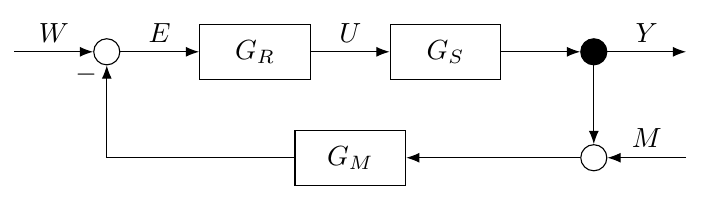

In [66]:
row = veritikz_dataset[i]
print(row["instruction"])
print(row["expected"])
open("notebooks/verifier_ds_creation/code.tex","w").write(row["solution"])
open("notebooks/verifier_ds_creation/originalcode.tex","w").write(row["original_template"])
display(row["solution_image"])
i+=1 

In [146]:
i

365

In [143]:
i=240

### some tests

In [3]:
import sys
from datasets import load_dataset, Dataset
from loguru import logger
from vif.utils.renderer.tex_renderer import TexRenderer

logger.configure(handlers=[{"sink": sys.stdout, "level": "WARNING"}])
veritikz_dataset = load_dataset("CharlyR/VeriTikz", "full", split="train")

renderer = TexRenderer()


def add_or_cust_image(row):
    row["theoretical_perfect_image"] = renderer.from_string_to_image(
        get_default(handle_def(row["original_template"])[0])
    )
    return row

updated_ds = veritikz_dataset.map(add_or_cust_image,num_proc=15)


Map (num_proc=15): 100%|██████████| 270/270 [00:23<00:00, 11.68 examples/s]


In [4]:
updated_ds.push_to_hub("CharlyR/VeriTikz", config_name="full", split="train")


Uploading the dataset shards: 100%|██████████| 2/2 [00:07<00:00,  3.52s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/CharlyR/VeriTikz/commit/b490a428580516af5b915634e7038e5b19ed2f11', commit_message='Upload dataset', commit_description='', oid='b490a428580516af5b915634e7038e5b19ed2f11', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/CharlyR/VeriTikz', endpoint='https://huggingface.co', repo_type='dataset', repo_id='CharlyR/VeriTikz'), pr_revision=None, pr_num=None)

In [1]:
from notebooks.verifier_ds_creation.invalid_variant_creation import apply_random_modifications


failing_code = open(".oui/original copy.tex").read()
apply_random_modifications(failing_code,1,1,3)

/home/creux/Documents/AI/VIFagent/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-30 11:20:52.859 | DEBUG    | vif.utils.renderer.tex_renderer:from_string_to_image:45 - latex renderer writing to /home/creux/.cache/varbench/890381ce-7c6f-4aac-9aab-d5f02f1bd830.tex
2025-10-30 11:20:53.319 | DEBUG    | vif.utils.renderer.tex_renderer:from_string_to_image:78 - converting /home/creux/.cache/varbench/890381ce-7c6f-4aac-9aab-d5f02f1bd830.tex to png
2025-10-30 11:20:53.343 | DEBUG    | vif.utils.renderer.tex_renderer:from_string_to_image:45 - latex renderer writing to /home/creux/.cache/varbench/e009dedc-df7c-4264-ba24-8b54091481f5.tex
2025-10-30 11:20:53.797 | DEBUG    | vif.utils.renderer.tex_renderer:from_string_to_image:78 - converting /home/creux/.cache/varbench/e009dedc-df7c-4264-ba24-8b5409

['\\documentclass[tikz,border=5]{standalone}\n\\usepackage[prefix=]{xcolor-material}\n\n\\tikzset{\nchimpanzee/.pic={\n\\tikzset{x=3cm/3.5,y=3cm/3.5, shift={(0,1/7)}}\n\\fill [BlueGrey700] (165:5/4 and 1) ellipse [radius=1/2];\n\\fill [Pink100]     (165:5/4 and 1) ellipse [radius=1/3];\n\\fill [BlueGrey700]\n  (0,-1/2) ellipse [x radius=1, y radius=4/3]\n  (0,   0) ellipse [x radius=4/3, y radius=1];\n\\scoped{\n  \\clip(0,-2) rectangle(9/5,1);\n  \\fill [BlueGrey900] (15:5/4 and 1) ellipse [radius=1/2];\n  \\fill [Pink200]     (15:5/4 and 1) ellipse [radius=1/3];\n  \\fill [BlueGrey900]\n    (0,-1/2) ellipse [x radius=1, y radius=4/3]\n    (0,   0) ellipse [x radius=4/3, y radius=1];\n}\n\\fill [Pink100]            (  0,-2/3) ellipse [x radius=5/6, y radius=  1];\n\\fill [Pink100, xscale=-1] (1/2,   0) ellipse [x radius=3/5, y radius=2/3];\n\\fill [Pink100, xscale= 1] (1/2,   0) ellipse [x radius=3/5, y radius=2/3];\n\\scoped{\n  \\clip(0,-2) rectangle(9/5,1);\n  \\fill [Pink200]     

In [2]:
test_row_code = ds.select([24])["template_solution_code"][0][0]
original_test_row_code = ds.select([25])["code"][0]
original_test_row_code

'\\documentclass[tikz,border=5]{standalone}\n\\usepackage{tikz}\n\\usetikzlibrary{\n                arrows.meta,\n                bending,\n                positioning\n               }\n\\tikzset{\n         > = Latex,\n         arrows = {[bend]},\n         signal/.style = coordinate,\n         sum/.style = {\n                       draw,\n                       circle,\n                       minimum size = 2mm\n                      },\n         block/.style = {\n                         draw,\n                         rectangle,\n                         minimum height = 2em,\n                         minimum width = 4em\n                        },\n         branch/.style = {\n                          sum,\n                          minimum size = 1mm,\n                          fill = black\n                         }\n        }\n\n\\begin{document}\n\n  \\begin{tikzpicture}[auto]\n\n    \\node[signal] (input) {};\n    \\node[sum, right = of input] (left sum) {};\n    \\node[block

In [ ]:
from notebooks.verifier_ds_creation.invalid_variant_creation import apply_random_modifications


new_code = apply_random_modifications(original_test_row_code)

In [5]:
from vif.utils.renderer.tex_renderer import TexRenderer


renderer = TexRenderer()
renderer.from_string_to_image(new_code)

TypeError: write() argument must be str, not tuple

In [ ]:
generate_all_incorrect_solutions(original_test_row_code,test_row_code)

In [ ]:
test_row = ds.select(range(24,100))
hu=test_row.map(create_incorrect_solutions,batched=True,batch_size=1,load_from_cache_file=False)


In [11]:
from notebooks.verifier_ds_creation.verifier_utils import all_incorrect_from_template


test_code="""

sq
§range(5,20,15)
qsdfqs
§rangei(25,5)
dsqqfqsdf
Red§choice([50,100,200],100)
Red§choice([50,100,200],100)
Red§choice([50,100,200],100)
Red§choice([50,100,200],100)

"""

all_incorrect_from_template(test_code)

['\n\nsq\n15\nqsdfqs\n25\ndsqqfqsdf\nRed100\nRed800\nRed600\nRed100\n\n',
 '\n\nsq\n15\nqsdfqs\n25\ndsqqfqsdf\nRed300\nRed100\nRed600\nRed100\n\n',
 '\n\nsq\n15\nqsdfqs\n33\ndsqqfqsdf\nRed100\nRed100\nRed500\nRed100\n\n',
 '\n\nsq\n24\nqsdfqs\n25\ndsqqfqsdf\nRed100\nRed100\nRed900\nRed100\n\n',
 '\n\nsq\n15\nqsdfqs\n25\ndsqqfqsdf\nRed600\nRed400\nRed100\nRed100\n\n',
 '\n\nsq\n15\nqsdfqs\n17\ndsqqfqsdf\nRed100\nRed400\nRed100\nRed100\n\n',
 '\n\nsq\n0\nqsdfqs\n25\ndsqqfqsdf\nRed100\nRed900\nRed100\nRed100\n\n',
 '\n\nsq\n15\nqsdfqs\n33\ndsqqfqsdf\nRed500\nRed100\nRed100\nRed100\n\n',
 '\n\nsq\n24\nqsdfqs\n25\ndsqqfqsdf\nRed800\nRed100\nRed100\nRed100\n\n',
 '\n\nsq\n24\nqsdfqs\n17\ndsqqfqsdf\nRed100\nRed100\nRed100\nRed100\n\n']

In [1]:

from notebooks.verifier_ds_creation.verifier_utils import create_arrangements


create_arrangements(5,-1,4)

/home/creux/Documents/AI/VIFagent/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[[1, 1, 1, 1, 0],
 [1, 1, 1, 0, 1],
 [1, 1, 0, 1, 1],
 [1, 0, 1, 1, 1],
 [0, 1, 1, 1, 1]]